In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import torch
import math
import time


### Preliminary Testing of Newton's Method

First, we will take a synthetic dataset and test Newton's Method. This will hopefully eliminate any errors that could occur because of the data.

In [2]:
%load_ext autoreload
%autoreload 2
from newton import LogisticRegression, GradientDescentOptimizer, NewtonOptimizer, AdamOptimizer, StandardSGD

In [3]:
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X.double(), y.double()

X, y = classification_data(noise = 0.5)

We will create two models: one that uses Newton's Method as the optimizer and one that uses the Gradient Descent Optimizer. We will then compare and check to see that the w vectors they create are approximately similar.

In [4]:
opt = NewtonOptimizer()
loss_arr = []
for _ in range(40):
    loss = opt.loss(X, y)
    loss_arr.append(loss)
    opt.step(X, y, alpha = 0.1)

In [5]:
opt2 = GradientDescentOptimizer()
loss_arr2 = []
for _ in range(150):
    loss = opt2.loss(X, y)
    loss_arr2.append(loss)
    opt2.step(X, y, alpha = 0.2, beta = 0)

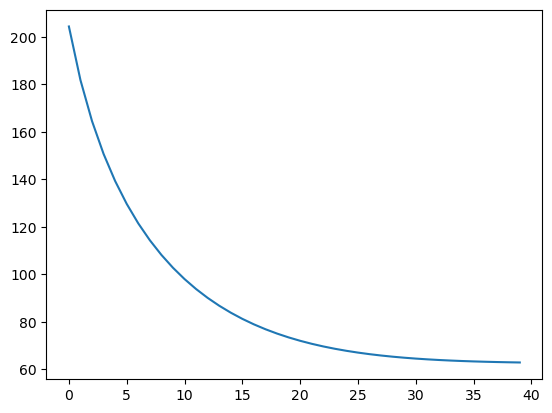

In [6]:
plt.plot(loss_arr)

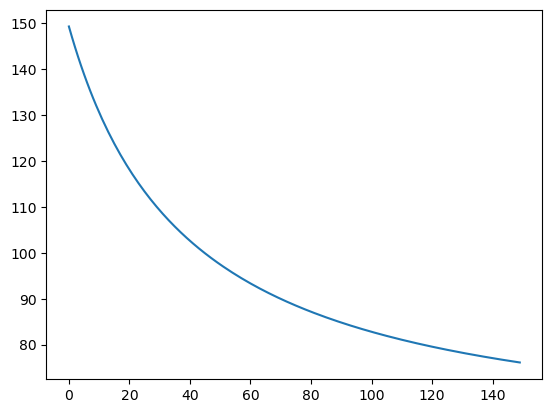

In [7]:
plt.plot(loss_arr2)

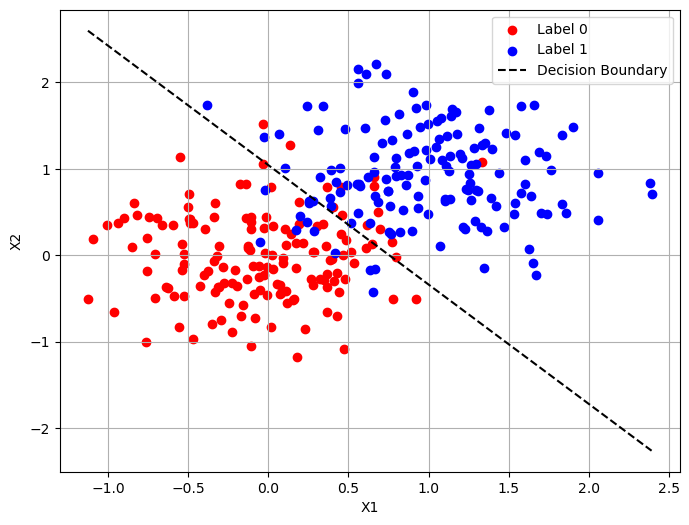

In [8]:
def plot_data_and_w(X, y, w):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='red', label='Label 0')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Label 1')

    # Decision boundary: w0*x + w1*y + w2 = 0
    x_vals = torch.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    if w[1] != 0:
        y_vals = -(w[0] * x_vals + w[2]) / w[1]
        plt.plot(x_vals, y_vals, 'k--', label='Decision Boundary')

    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_data_and_w(X, y, opt.w)

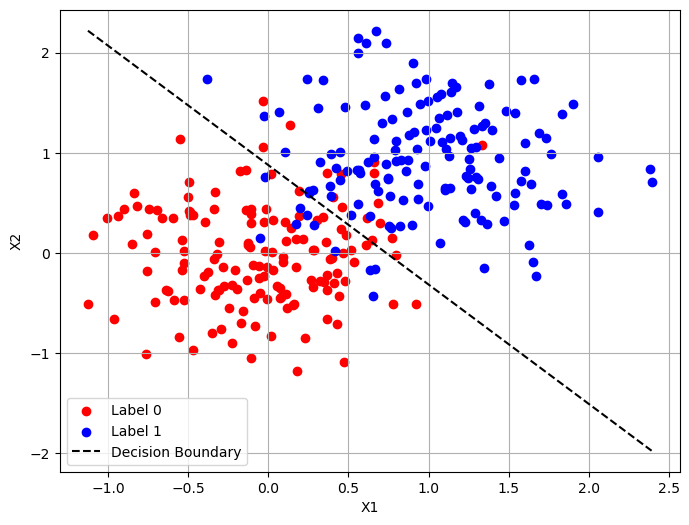

In [9]:
def plot_data_and_w(X, y, w):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='red', label='Label 0')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Label 1')

    # Decision boundary: w0*x + w1*y + w2 = 0
    x_vals = torch.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    if w[1] != 0:
        y_vals = -(w[0] * x_vals + w[2]) / w[1]
        plt.plot(x_vals, y_vals, 'k--', label='Decision Boundary')

    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_data_and_w(X, y, opt2.w)

In [10]:
print(opt.w, opt2.w)

tensor([ 3.8513,  2.7875, -2.9071], dtype=torch.float64) tensor([ 2.0984,  1.7615, -1.5457], dtype=torch.float64)


We can see that although the w vectors are slightly different, they both separate the data pretty well. This could also be because Newton converged much more quickly than Gradient Descent, and therefore Gradient Descent could possibly converge slightly more and meet the w values for Newton.

### Newton's Method Experiments

It took me a long time to find a dataset that worked well for Newton's method. Since the step function finds the inverse of the Hessian Matrix, I was running into issues where the Hessian was singular and therefore could not be inverted. I tried using pinverse to approximate the inverse, but unfortunately that slowed down the algorithm drastically.

In [11]:
df = pd.read_csv("/Users/ellisterling/Documents/spring25/csci0451/ellisterling.github.io/posts/newton/data/Titanic-Dataset.csv")
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [12]:
filter = ["Pclass", "Sex", "Age", "Fare", "Survived"]

<Axes: xlabel='Fare', ylabel='Age'>

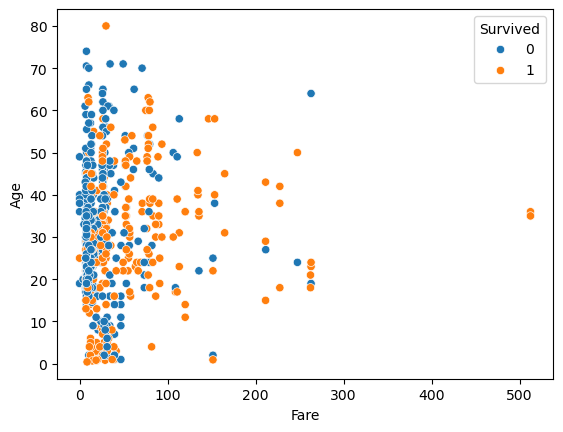

In [13]:
# fig, ax = plt.subplots(1, 1, figsize = (6, 4))
# hist = ax.hist(df['Location'], bins = 50, color = "steelblue", alpha = 0.6, linewidth = 1, edgecolor = "black")
# |sns.countplot(df[df["Preference"] == 0], x = "Environmental_Concerns", hue = "Preference")
# sns.scatterplot(df, x = "Proximity_to_Mountains", y = "Vacation_Budget", hue = "Preference")
# sns.countplot(df, x = "Pclass", hue = "Survived")
sns.scatterplot(df, x = "Fare", y = "Age", hue = "Survived")

In [14]:
df.groupby("Survived")["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [15]:
df = df[filter]
df = df.dropna()
df = pd.get_dummies(df)

In [16]:
df_train, df_test = train_test_split(df, test_size = 0.3)
X_train = df_train.drop("Survived", axis=1)
y_train = df_train["Survived"]
X_test = df_test.drop("Survived", axis=1)
y_test = df_test["Survived"]

In [17]:
X_train_tensor = torch.from_numpy(X_train.to_numpy().astype(float))
X_test_tensor = torch.from_numpy(X_test.to_numpy().astype(float))
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float)


In [18]:
X_train_tensor = X_train_tensor.double()
X_train_tensor
y_train_tensor = y_train_tensor.double()
X_test_tensor = X_test_tensor.double()
y_test_tensor = y_test_tensor.double()

In [19]:
opt3 = NewtonOptimizer()
loss_arr3 = []

In [20]:
# for _ in range(150):
newton_start_time = time.time()
loss = math.inf
while loss >= 240 or torch.isnan(loss):
    loss = opt3.loss(X_train_tensor, y_train_tensor)
    loss_arr3.append(loss)
    opt3.step(X_train_tensor, y_train_tensor, alpha = 0.001)
newton_end_time = time.time()

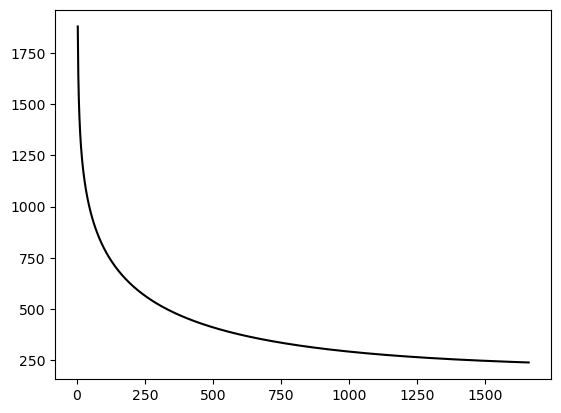

In [21]:
plt.plot(torch.arange(1, len(loss_arr3)+1), loss_arr3, color = "black")

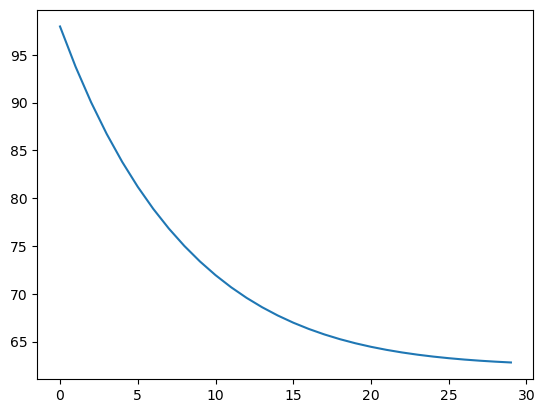

In [22]:
plt.plot(loss_arr[10:])

Inspect the weight vector:

In [23]:
opt3.w

tensor([-9.1277e-01, -3.1313e-02,  1.3956e-04,  4.3116e+00,  2.3760e+00],
       dtype=torch.float64)

In [24]:
y_test_tensor

tensor([0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1.,
        0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0.,
        0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
        1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
        0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1.,
        1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0.],
       dtype=torch.float64)

In [25]:
predicted = opt3.predict(X_test_tensor)
predicted

tensor([0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
        0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
        1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
        1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
        0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0.])

Let's check the accuracy:

In [26]:
#find score
(predicted == y_test_tensor).sum()/len(predicted)

tensor(0.7767)

Pretty good! It would be hard to visualize a 5d vector like this on a plot as we did with the synthetic data, but the score on our data is pretty good. Let's look at the confusion matrix too:

In [27]:
#find confusion matrix
from sklearn.metrics import confusion_matrix
C = confusion_matrix(y_test_tensor, predicted)
C

array([[97, 27],
       [21, 70]])

Now, let's make an example where alpha is too large and Newton's method fails to converge.

In [28]:
opt4 = NewtonOptimizer()
loss_arr4 = []

In [29]:
for _ in range(2500):
    loss = opt4.loss(X_train_tensor, y_train_tensor)
    loss_arr4.append(loss)
    opt4.step(X_train_tensor, y_train_tensor, alpha = 0.001)

In [30]:
loss_arr4

[tensor(nan, dtype=torch.float64),
 tensor(nan, dtype=torch.float64),
 tensor(nan, dtype=torch.float64),
 tensor(nan, dtype=torch.float64),
 tensor(nan, dtype=torch.float64),
 tensor(nan, dtype=torch.float64),
 tensor(nan, dtype=torch.float64),
 tensor(nan, dtype=torch.float64),
 tensor(nan, dtype=torch.float64),
 tensor(nan, dtype=torch.float64),
 tensor(nan, dtype=torch.float64),
 tensor(nan, dtype=torch.float64),
 tensor(nan, dtype=torch.float64),
 tensor(nan, dtype=torch.float64),
 tensor(nan, dtype=torch.float64),
 tensor(nan, dtype=torch.float64),
 tensor(nan, dtype=torch.float64),
 tensor(nan, dtype=torch.float64),
 tensor(nan, dtype=torch.float64),
 tensor(nan, dtype=torch.float64),
 tensor(nan, dtype=torch.float64),
 tensor(nan, dtype=torch.float64),
 tensor(nan, dtype=torch.float64),
 tensor(nan, dtype=torch.float64),
 tensor(nan, dtype=torch.float64),
 tensor(nan, dtype=torch.float64),
 tensor(nan, dtype=torch.float64),
 tensor(nan, dtype=torch.float64),
 tensor(nan, dtype=t

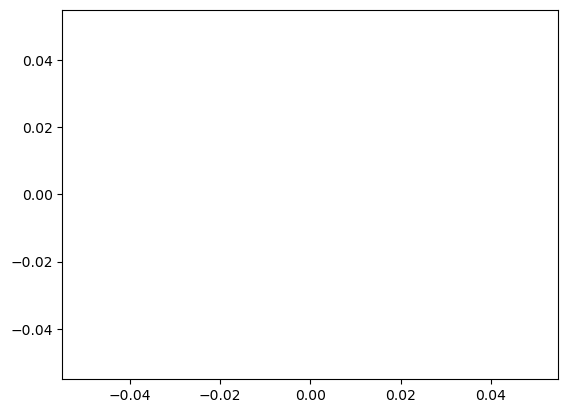

In [31]:
plt.plot(torch.arange(1, len(loss_arr4)+1), loss_arr4, color = "black")

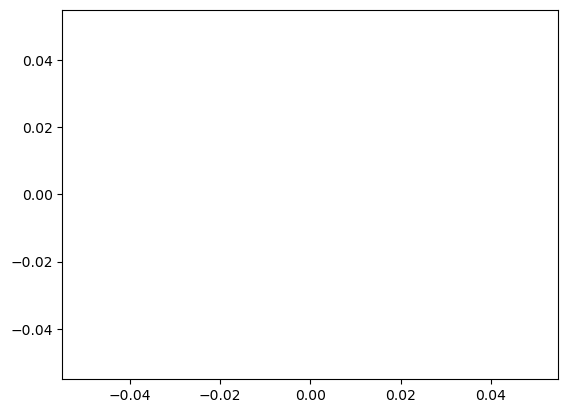

In [32]:
plt.plot(loss_arr4[10:])

In [33]:
predicted = opt4.predict(X_test_tensor)
(predicted == y_test_tensor).sum()/len(predicted)

tensor(0.4279)

In [34]:
adam = AdamOptimizer()
adam_loss = []

In [35]:

t = 1
loss = math.inf
adam_start_time = time.time()
# for t in range(1, 2000):
while loss >= 240 or torch.isnan(loss):
    loss = adam.loss(X_train_tensor, y_train_tensor)
    adam_loss.append(loss)
    adam.step(X_train_tensor, y_train_tensor, 10, 0.001, 0.9, 0.999, t)
adam_end_time = time.time()

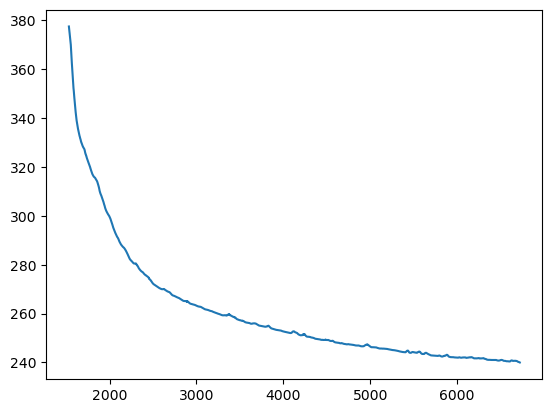

In [36]:
plt.plot(adam_loss)

In [37]:
predicted = adam.predict(X_test_tensor)
(predicted == y_test_tensor).sum()/len(predicted)

tensor(0.7581)

In [38]:
adam_time = adam_end_time - adam_start_time
newton_time = newton_end_time - newton_start_time
print(f"Newton Time: {newton_time}\nAdam Time: {adam_time}")

Newton Time: 1.046778917312622
Adam Time: 0.8173220157623291


In [39]:
sgd = StandardSGD()
sgd_loss = []

In [40]:
for t in range(200):
    loss = sgd.loss(X_train_tensor, y_train_tensor)
    sgd_loss.append(loss)
    sgd.step(X_train_tensor, y_train_tensor, 10, 0.0001, t)

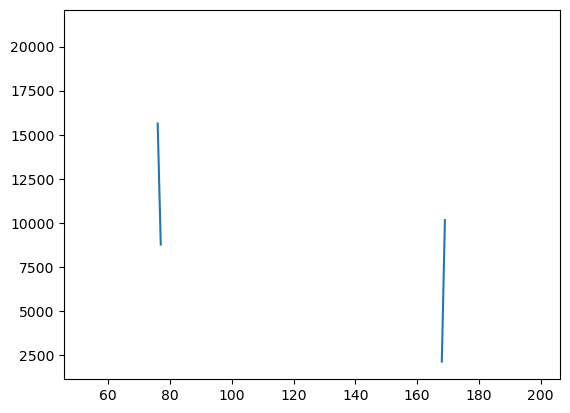

In [41]:
plt.plot(sgd_loss)